# Computational Intelligence in Chemistry - Hands-on Active Learning
### Luis Filipe Menezes - RA: 164924
This is part of an assignment for the Computational Intelligence in Chemistry course on UNIFESP's masters program.

This notebook must:

I. Use the full QM9 dataset.

II. Select one representation for the molecules (EV-CM,
MBTR, Mordred, etc.)

III. Setup a topline predictor:
  - I.Select a method, e.g., MLP, RF, KRR, etc.,
  - II.Split the dataset into train (80%), validation (10%) and test (10%)
  - III.Perform the model hyperparameter tuning

IV. Evaluate the final model with the test set

IV. Active Learning: Committee-base approach
  - I. Using the baseline model established in step III: train multiple regressors (with different seed and small hyperparameters modifications)
  - II.Use a subset of 1% of the training data to build the initial models
  - III.At each step of the active learning loop, select new samples from the training data (the number of samples must be evaluated – select a small number)
  - IV.Update the model with the new samples

V. Plot a graph showing the Error measurement versus the percentage of samples used for training

VI. Compare the active learning results with a passive (random) selection

## I. Loading the full QM9 dataset

In [1]:
!pip install --quiet dscribe

In [2]:
!wget -O data.tar.bz2 https://www.dropbox.com/scl/fi/2ugqxr9fa9nob1byc8ura/dsgdb9nsd.xyz.tar.bz2?rlkey=pp2k6fy4360yldrypwghwbi6d&st=1cohswqh&dl=0
!!mkdir qm9_files
!tar -xjf data.tar.bz2 -C qm9_files/

--2025-11-17 13:02:56--  https://www.dropbox.com/scl/fi/2ugqxr9fa9nob1byc8ura/dsgdb9nsd.xyz.tar.bz2?rlkey=pp2k6fy4360yldrypwghwbi6d
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc98921f81139f6c0c48b1b8c49b.dl.dropboxusercontent.com/cd/0/inline/C1UpepAhjM_8nC3PIWnBWldVs5TGGpZmH4R7UrMPKjV7P-r-bUi-nN74F8n5SN8d8hU0k_Oa9tT1EwemLepckMEc9yDfxdQ0nGO27gR0KAfE94uMIav5YDhMILsLF8n7sG5miedoRFcWtNNui7WURgVh/file# [following]
--2025-11-17 13:02:57--  https://uc98921f81139f6c0c48b1b8c49b.dl.dropboxusercontent.com/cd/0/inline/C1UpepAhjM_8nC3PIWnBWldVs5TGGpZmH4R7UrMPKjV7P-r-bUi-nN74F8n5SN8d8hU0k_Oa9tT1EwemLepckMEc9yDfxdQ0nGO27gR0KAfE94uMIav5YDhMILsLF8n7sG5miedoRFcWtNNui7WURgVh/file
Resolving uc98921f81139f6c0c48b1b8c49b.dl.dropboxusercontent.com (uc98921f81139f6c0c48b1b8c49b.dl.dropboxusercontent.com)... 162.125.5.1

In [1]:
qm9_folder = 'qm9_files/'
QM9_PROPERTIES = [
    "A", 'B', 'C', 'mu', 'alpha',
    'homo', 'lumo', 'gap', 'r2',
    'zpve', 'U0', 'U', 'H', 'G', 'Cv'
]


with open(qm9_folder+'dsgdb9nsd_113885.xyz') as file:
  for line in file:
    print(line)

19

gdb 113885	3.70802	0.80999	0.7081	2.6975	73.65	-0.2639	0.0141	0.278	1593.5236	0.156316	-460.174889	-460.164623	-460.163679	-460.212278	35.326	

C	-0.008898706	 1.435343511	-0.1229342875	-0.480889

C	-0.097211668	-0.0611740136	 0.0533750899	 0.431334

O	-0.522805097	-0.6329577977	 1.0223608396	-0.34442

O	 0.3874153201	-0.692641184	-1.0454419183	-0.247509

C	 0.3502508225	-2.1099666389	-1.0216443391	 0.118249

C	-0.6452778548	-2.8049992501	-1.9010293635	-0.305338

C	 0.8299955957	-2.806393386	-2.257736521	-0.04378

C	 1.3090797685	-2.0281448361	-3.4552388748	-0.093611

O	 1.0953742585	-2.8320000843	-4.6085691448	-0.419869

H	-0.3728027153	 1.9278328937	 0.7777832851	 0.149542

H	 1.0248947898	 1.7315350968	-0.3210999853	 0.149596

H	-0.6070917791	 1.7459702376	-0.9844780335	 0.149165

H	 0.576972916	-2.5190329042	-0.0453019279	 0.12476

H	-1.1102986284	-3.7153217605	-1.5406769745	 0.122235

H	-1.2860640388	-2.1730656326	-2.5065209428	 0.123942

H	 1.3703384329	-3.7344941519	-2.09474

In [2]:
import os
import pandas as pd
import numpy as np
from ase import Atoms


np.random.seed(24)
N_SUBSET_SAMPLES = 5000

def load_validate_mol(file_string):
  with open(file_string, 'r') as file:
    n_atoms = int(file.readline())

    properties_list = file.readline().split()
    mol_id = properties_list[1]
    properties_values = [float(prop) for prop in properties_list[2:]]
    properties_dict = dict(zip(QM9_PROPERTIES, properties_values))


    atoms = []
    atoms_coords = []
    for nlines in range(n_atoms):
      atom_info = file.readline().split()
      atoms.append(atom_info[0]) # get only the the atom string

      atom_coords_str = atom_info[1:4]
      # print(atom_coords)
      try:
        atom_coords = [float(coord.replace('*^', 'e')) for coord in atom_coords_str]
        atoms_coords.append(atom_coords)

      except Exception as e:
        print(f"Couldn't extract xyz from file {file_string}: ", e)
      # print(atom_info)
    # print(atoms)
    file.readline() # ignores the frequencies

    # smiles_list = file.readline().split()


    # mol = Chem.MolFromSmiles(smiles_list[0]) # If it's None then smiles is invalid
    # if mol is None:
    #     print("Invalid smiles for arquive: ", mol_id)
    #     return
    # canon_smiles = Chem.CanonSmiles(smiles_list[0])

    mol_ase = Atoms(symbols=atoms, positions= atoms_coords)

    molecule_data = {
                'id': mol_id,
                'n_atoms': n_atoms,
                'atom_list': atoms,
                'atom_coords': atoms_coords,
                'mol_ase': mol_ase,
                # 'smiles': canon_smiles,
            }
            # Adiciona as 12 propriedades ao dicionário principal
    molecule_data.update(properties_dict)
    return molecule_data


def get_full_dataset(folder):
  dataset_list = []
  # print(f"Lendo arquivos da pasta: {folder}")

  files_to_process = [f for f in os.listdir(folder) if f.endswith('.xyz')]

  # files_to_process = np.random.choice(files_to_process, size=N_SUBSET_SAMPLES, replace=False)

  n_max_atoms = -1

  for i, file in enumerate(files_to_process):

      if (i + 1) % 10000 == 0:
          print(f"  Processando arquivo {i+1}/{len(files_to_process)}...")

      file_path = os.path.join(folder, file)

      # Chama a função de processamento para um arquivo
      molecule_data = load_validate_mol(file_path)

      n_atoms = molecule_data['n_atoms']
      if n_atoms > n_max_atoms:
          n_max_atoms = n_atoms
      # Se a função retornou dados válidos (não None), adiciona à lista
      if molecule_data:
          dataset_list.append(molecule_data)
  return dataset_list, n_max_atoms




if __name__ == '__main__':
  full_dataset, n_max_atoms = get_full_dataset(qm9_folder)

  df = pd.DataFrame(full_dataset)
  display(df.head())
  # print(load_validate_mol(qm9_folder+'dsgdb9nsd_113885.xyz')['atom_coords'])

  Processando arquivo 10000/133885...
  Processando arquivo 20000/133885...
  Processando arquivo 30000/133885...
  Processando arquivo 40000/133885...
  Processando arquivo 50000/133885...
  Processando arquivo 60000/133885...
  Processando arquivo 70000/133885...
  Processando arquivo 80000/133885...
  Processando arquivo 90000/133885...
  Processando arquivo 100000/133885...
  Processando arquivo 110000/133885...
  Processando arquivo 120000/133885...
  Processando arquivo 130000/133885...


,id,n_atoms,atom_list,atom_coords,mol_ase,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
0,24741,12,"[O, C, C, C, C, N, C, C, O, H, H, H]","[[-0.0699318951, -0.0169722532, 0.0037600727],...","(Atom('O', [np.float64(-0.0699318951), np.floa...",3.82396,1.27192,0.95445,2.8364,72.43,-0.2671,-0.0895,0.1776,1120.5408,0.077210,-435.486068,-435.478661,-435.477717,-435.518646,26.421
1,59013,18,"[C, C, O, C, C, N, C, O, C, H, H, H, H, H, H, ...","[[-0.09942628, 1.5073785573, -0.060469828], [-...","(Atom('C', [np.float64(-0.09942628), np.float6...",3.61630,0.95013,0.88882,4.2815,75.84,-0.2121,-0.0008,0.2113,1353.0529,0.146822,-439.132298,-439.123186,-439.122242,-439.166452,33.758
2,42891,17,"[N, C, N, C, C, C, C, C, O, H, H, H, H, H, H, ...","[[-0.2258662223, 1.1701323106, -0.0879709741],...","(Atom('N', [np.float64(-0.2258662223), np.floa...",2.92914,1.57965,1.28871,3.2970,73.68,-0.2413,-0.0076,0.2337,1016.4167,0.136524,-417.938580,-417.930940,-417.929996,-417.971120,28.931
3,94738,19,"[C, C, O, C, C, O, C, O, C, H, H, H, H, H, H, ...","[[0.1258777725, 1.5942270676, 0.0153026654], [...","(Atom('C', [np.float64(0.1258777725), np.float...",2.74888,1.55133,1.26997,2.0216,70.81,-0.2498,0.0517,0.3015,1055.6243,0.158836,-460.147456,-460.139036,-460.138092,-460.180167,32.230
4,34702,15,"[N, C, C, C, C, C, C, C, N, H, H, H, H, H, H]","[[-0.1092509968, -1.1317928833, -0.1375915342]...","(Atom('N', [np.float64(-0.1092509968), np.floa...",5.18897,1.33325,1.31918,3.3817,71.48,-0.2512,0.0216,0.2728,950.8314,0.114945,-379.590819,-379.584660,-379.583716,-379.621414,24.793


# II. Molecules representation.

We will use the Coulomb Matrix since it can represent the eletronic properties at a low computational cost. Other tests with the MBTR  descriptor for the full dataset have crashed Colab's local RAM.

In [3]:
from dscribe.descriptors import CoulombMatrix, MBTR

ev_cm = CoulombMatrix(n_atoms_max=n_max_atoms, permutation='eigenspectrum')

ev_cm_descriptors = ev_cm.create(df['mol_ase'], n_jobs=-1)

print(ev_cm_descriptors[0])

[203.53045209  77.30308229  49.75955177  39.8116953   27.73080865
  13.21845693   6.40199004   5.63657148   1.46373806  -0.80071863
  -0.7598336   -0.25506634   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]


# III. Setup topline predictor

We will use an MLP approach, since we do not have the full description provided by MBTR we might need more complexes models to best suit our prediction problem.

### I. Preprocessing data

Using Stardard Scaler and dividing the dataset as $20\%$ test subset.

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

X_processed = scaler.fit_transform(ev_cm_descriptors)
y = df['Cv']
# y_processed = scaler.fit_transform(df[QM9_PROPERTIES])

In [42]:
X_dev, X_test, y_dev, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=24)

### III. Hyperparameter tuning

We will use cross-validation to select the best hyperparameters configuration for the MLP model.

In [56]:
import keras
from keras.layers import Dense, Input

def create_model():
  mlp = keras.Sequential()
  mlp.add(Input(shape=(X_dev.shape[1],)))
  mlp.add(Dense(124, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
  mlp.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
  mlp.add(Dense(1, activation='linear'))

  mlp.compile(optimizer='adam', loss='mae', metrics=['r2_score'])
  return mlp

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=24)

cv_scores = []
r2_cv_scores = []
fold_no = 1

# 3. The Loop
for train_index, val_index in kf.split(X_dev, y_dev):
    print(f'Training Fold {fold_no}...')

    # Split data based on the indices provided by KFold
    X_train_fold, X_val_fold = X_dev[train_index], X_dev[val_index]
    y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

    model = create_model()

    # Fit the model
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=50,          
        batch_size=64,
        verbose=0,          
        validation_data=(X_val_fold, y_val_fold)
    )

    
    # Evaluate
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Fold {fold_no} MAE: {scores[0]:.4f}') # scores[0] is the metric (MAE)

    cv_scores.append(scores[0])
    r2_cv_scores.append(scores[1])
    fold_no += 1

print(f'Average CV MAE: {np.mean(cv_scores):.4f}')
print(f'Average CV R2: {np.mean(r2_cv_scores):.4f}')

Training Fold 1...


2025-11-17 15:26:35.718522: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:26:35.718538: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:26:35.718554: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:26:36.087207: I external/l

Fold 1 MAE: 0.6391
Training Fold 2...
Fold 2 MAE: 0.6068
Training Fold 3...


2025-11-17 15:28:36.119370: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:28:36.119386: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:28:36.119412: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:28:36.487319: I external/l

Fold 3 MAE: 0.5766
Average CV MAE: 0.6075
Average CV R2: 0.9643


#### Training final model

In [70]:
model = create_model()
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.1, random_state=24)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64, 
    validation_data=(X_val, y_val),
    verbose=0
)

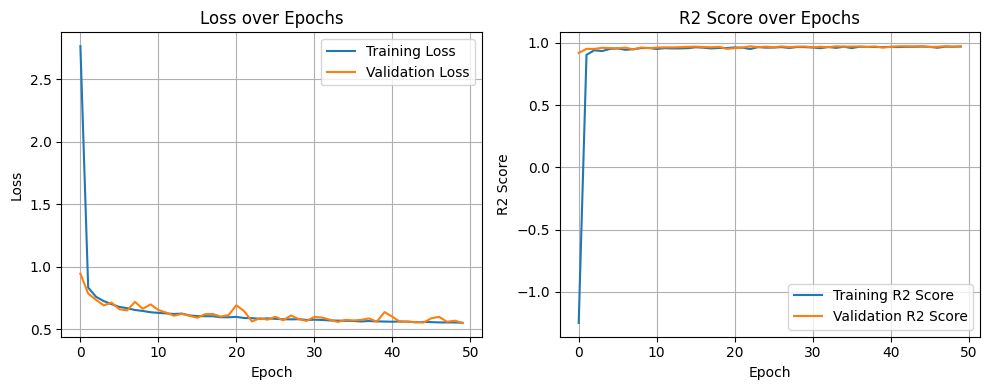

In [71]:
def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['r2_score'], label='Training R2 Score')
    plt.plot(history.history['val_r2_score'], label='Validation R2 Score')
    plt.title('R2 Score over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

### IV Analising in the test subset

837/837 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step


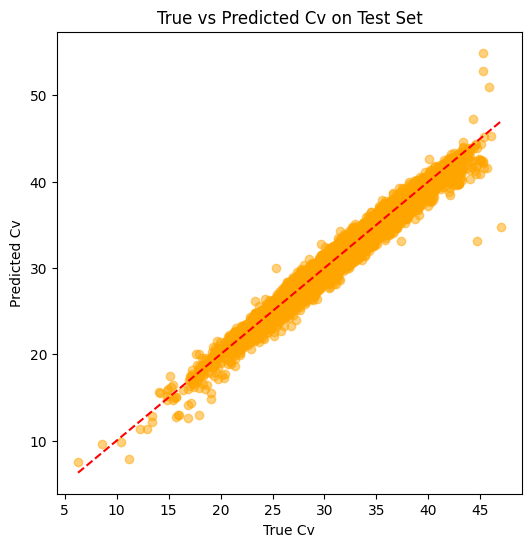

In [72]:
y_pred = model.predict(X_test)
test_metrics = model.evaluate(X_test, y_test, verbose=0)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, c='orange')
plt.xlabel('True Cv')
plt.ylabel('Predicted Cv')
plt.title('True vs Predicted Cv on Test Set')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

In [73]:
print(f'Test MAE: {test_metrics[0]:.4f}')
print(f'Test R2: {test_metrics[1]:.4f}')

Test MAE: 0.5446
Test R2: 0.9736


837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
MAE=0.4954, RMSE=0.6592, R2=0.9736


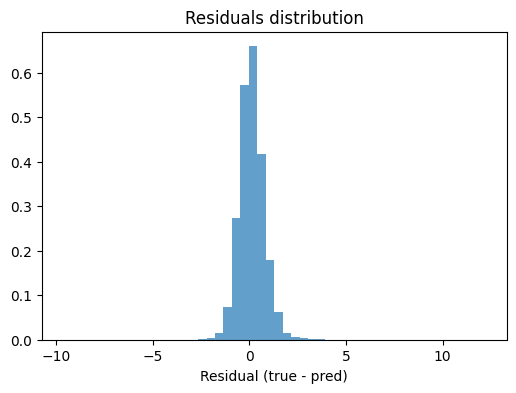

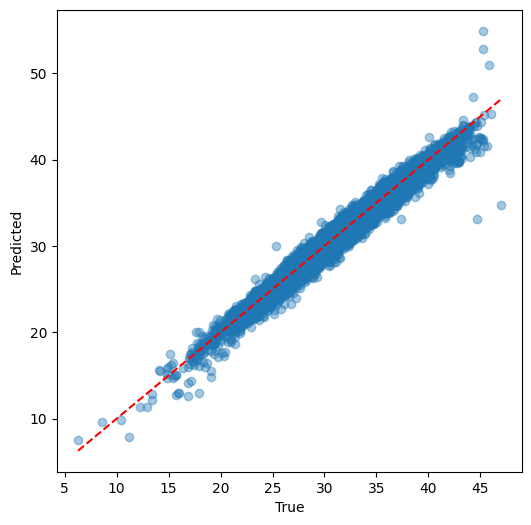

In [74]:
# Python: common metrics + residual plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).ravel()
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, density=True, alpha=0.7)
plt.title('Residuals distribution')
plt.xlabel('Residual (true - pred)')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'r--')
plt.xlabel('True'); plt.ylabel('Predicted')
plt.show()

In [76]:
# Bootstrap CI for MAE
import numpy as np
n_boot = 1000
maes = []
rng = np.random.RandomState(0)
for _ in range(n_boot):
    idx = rng.choice(len(y_test), len(y_test), replace=True)
    maes.append(mean_absolute_error(y_test.iloc[idx], y_pred[idx]))
np.percentile(maes, [2.5, 50, 97.5])

array([0.48998256, 0.49535057, 0.50063103])